         Date         Open         High          Low        Close  \
0  2023-08-14  1611.000000  1615.000000  1600.250000  1610.900024   
1  2023-08-16  1583.099976  1609.650024  1581.300049  1606.199951   
2  2023-08-17  1597.599976  1609.900024  1594.000000  1597.300049   
3  2023-08-18  1587.550049  1596.300049  1585.500000  1590.750000   
4  2023-08-21  1600.500000  1600.500000  1587.000000  1589.500000   

     Adj Close    Volume  
0  1589.198853  15652205  
1  1584.562012  17068771  
2  1575.782104  26442020  
3  1569.320190  12816683  
4  1568.087036  10918635  


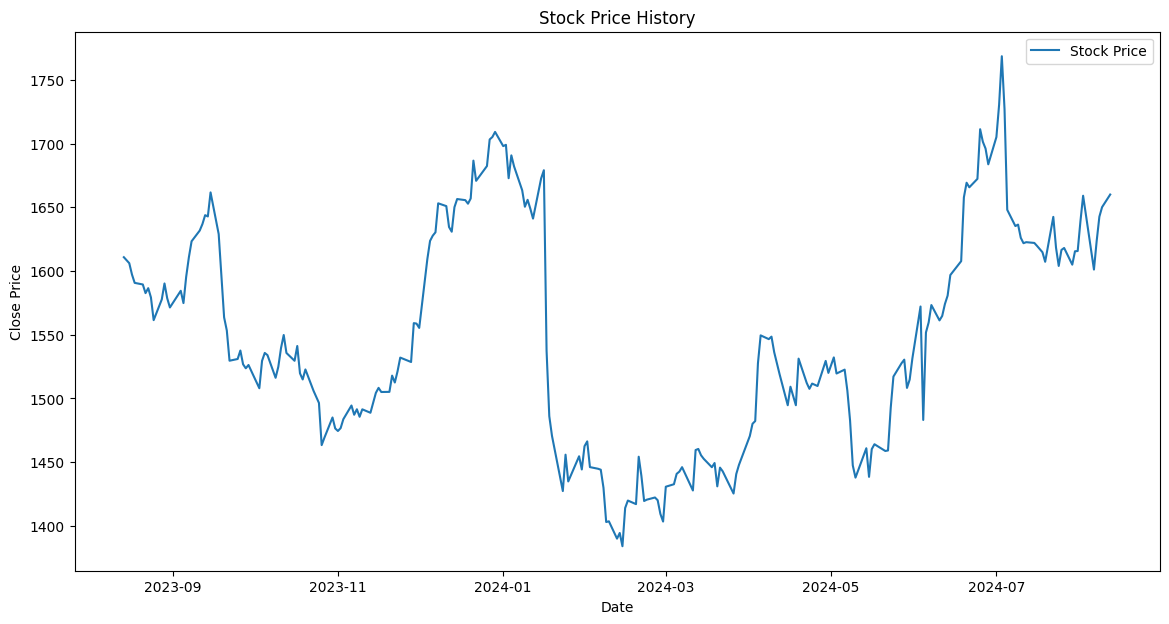

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 253ms/step - loss: 0.1116 - val_loss: 0.0187
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0465 - val_loss: 0.0050
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0319 - val_loss: 0.0376
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0331 - val_loss: 0.0475
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0330 - val_loss: 0.0318
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0277 - val_loss: 0.0141
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0233 - val_loss: 0.0066
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0235 - val_loss: 0.0062
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0232 - val_loss: 0.0111
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0172 - val_loss: 0.0137
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0183 - val_loss: 0.0141
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0160 - val_loss: 0.0131

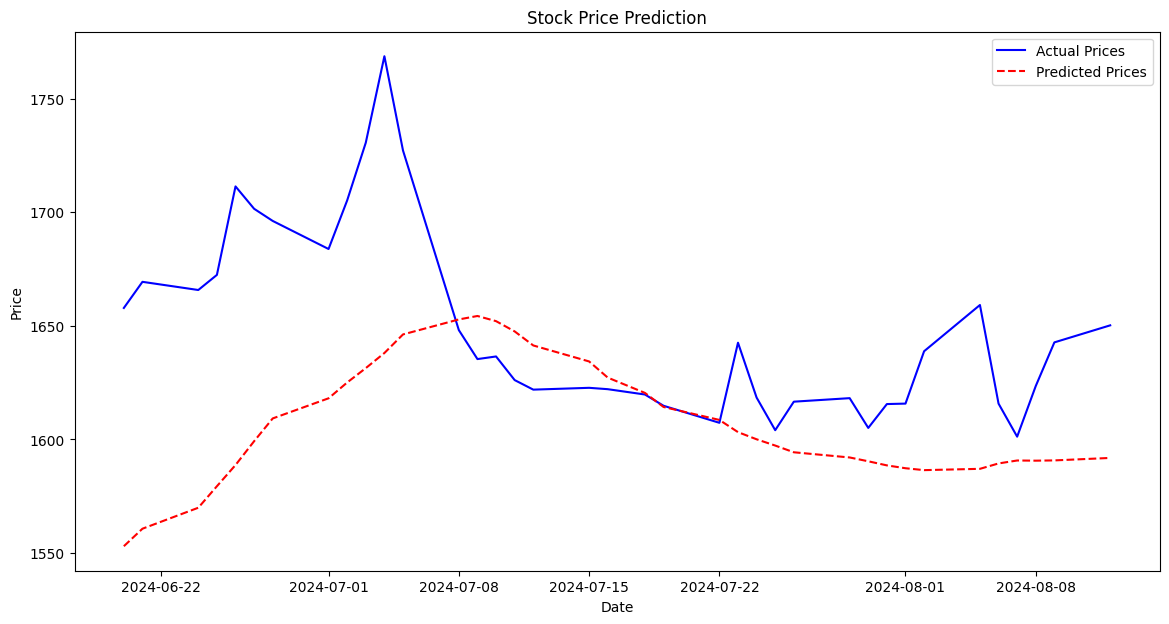

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import os
import tensorflow as tf

# Suppress all warnings
warnings.filterwarnings('ignore')

# Set environment variable for TensorFlow
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Configure TensorFlow logging to show only errors
tf.get_logger().setLevel('ERROR')



# Load the dataset
data = pd.read_csv('D:\Code Alpha\Task 2\HDFCBANK.csv', date_format=True)
print(data.head())
data = data[['Date', 'Close']]
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Stock Price')
plt.title('Stock Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Prepare the data for LSTM
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Reshape for LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

from tensorflow.keras.layers import Input

# Define the model using the Input layer
model = Sequential()
model.add(Input(shape=(time_step, 1)))  # Define the input shape here
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])


# Predicting the stock price
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform([y_test])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv[0], predictions[:, 0]))
print(f'Root Mean Squared Error: {rmse}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test_inv[0], color='blue', label='Actual Prices')
plt.plot(data.index[-len(predictions):], predictions, color='red', linestyle='dashed', label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

